##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Colab stuff

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install gensim==3.8.1
!pip install sacrebleu

In [0]:
import os
os.chdir(os.path.join('drive', 'My Drive', 'ift6759', 'ift6759-t6-p2'))
os.getcwd()

### imports

In [0]:
import tensorflow as tf
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import sacrebleu

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from dataloader.dataloader import get_dataset_train
from utils.data import preprocess_v2id, postprocessing
from utils.data import save_json, load_json, swap_dict_key_value, checkout_data

### Dataloader

In [0]:
def encoder_preprocess(data):
    encoder_v2id, encoder_dataset = preprocess_v2id(
            data=data,
            v2id=os.path.join("language_models","unformated_en_w2w", "v2id.json"),
            tokenize_type="w",
            max_seq=None,
            remove_punctuation=True,
            lower=False,
            threshold=0.85,
            CAP=True,
            NUM=True,
            ALNUM=True,
            UPPER=True,
            fasttext_model="/content/drive/My Drive/ift6759/ift6759-t6-p2/embeddings/unformated_en_w2w/128/unaligned_unformated_en",
    )
    encoder_id2v = swap_dict_key_value(encoder_v2id)
    return encoder_dataset, encoder_v2id, encoder_id2v

def decoder_preprocess(data):
    decoder_v2id, decoder_dataset = preprocess_v2id(
            data=data,
            v2id=os.path.join("language_models","formated_fr_w2w", "v2id.json"),
            tokenize_type="w",
            max_seq=None,
            remove_punctuation=False,
            lower=False,
            threshold=0.85,
            CAP=True,
            NUM=True,
            ALNUM=True,
            UPPER=True,
            fasttext_model="/content/drive/My Drive/ift6759/ift6759-t6-p2/embeddings/formated_fr_w2w/128/unaligned_formated_fr",
    )
    decoder_id2v = swap_dict_key_value(decoder_v2id)
    return decoder_dataset, decoder_v2id, decoder_id2v


In [13]:
encoder_dataset, encoder_v2id, encoder_id2v = encoder_preprocess(data="/content/drive/My Drive/ift6759/ift6759-t6-p2/data/aligned_unformated_en")
decoder_dataset, decoder_v2id, decoder_id2v = decoder_preprocess(data="/content/drive/My Drive/ift6759/ift6759-t6-p2/data/aligned_formated_fr")

100%|██████████| 11000/11000 [01:01<00:00, 180.26it/s]


In [0]:
(
    input_tensor_train,
    input_tensor_valid,
    target_tensor_train,
    target_tensor_valid
) = train_test_split(encoder_dataset, decoder_dataset, test_size=0.2, shuffle=False)

In [0]:
BUFFER_SIZE = len(input_tensor_train)
batch_size = 32
dataset_train = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)).batch(batch_size, drop_remainder=False)
dataset_valid = tf.data.Dataset.from_tensor_slices(
    (input_tensor_valid, target_tensor_valid)).batch(batch_size, drop_remainder=False)


#### View data sample

In [16]:
for i,j in dataset_train:
  for z in i[10].numpy():
    print(encoder_id2v[z], end = ' ')
  print("\n")
  for z in j[10].numpy():
    print(decoder_id2v[z], end = ' ')
  print("\n")
  break

for i,j in dataset_valid:
  for z in i[0].numpy():
    print(encoder_id2v[z], end = ' ')
  print("\n")
  for z in j[0].numpy():
    print(decoder_id2v[z], end = ' ')
  print("\n")
  break


<SOS> regulation applying a scheme of generalised tariff preferences vote <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

<SOS> <CAP> règlement appliquant un schéma de préférences tarifaires généralisées <UNK> vote <UNK> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

# Transformer model for language understanding

## Positional encoding


In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

## Masking

In [0]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [0]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Scaled dot product attention

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [0]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

## Multi-head attention

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

## Point wise feed forward network

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Encoder and decoder

### Encoder layer

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

### Decoder layer

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

### Encoder

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

### Decoder

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## Create the Transformer

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

## Set hyperparameters

In [0]:
num_layers = 2
d_model = 128
dff = 512
num_heads = 16

input_vocab_size = len(encoder_v2id) + 1
target_vocab_size = len(decoder_v2id) + 1
dropout_rate = 0.3

## Optimizer

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

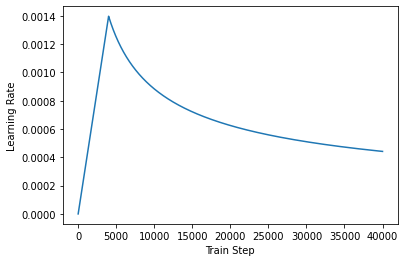

In [34]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='valid_accuracy')

## Training and checkpointing

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [0]:
checkpoint_path = "./checkpoints/train/w2w/unformated_en_2_formated_fr"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50)

In [0]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [0]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  train_loss(loss)
  train_accuracy(tar_real, predictions)

@tf.function(input_signature=train_step_signature)
def valid_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  predictions, _ = transformer(inp, tar_inp, 
                                True, 
                                enc_padding_mask, 
                                combined_mask, 
                                dec_padding_mask)
  loss = loss_function(tar_real, predictions)
  valid_loss(loss)
  valid_accuracy(tar_real, predictions)

In [0]:
EPOCHS = 28

In [484]:
for epoch in tqdm(range(EPOCHS)):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  valid_loss.reset_states()
  valid_accuracy.reset_states()
  

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(dataset_train):
    train_step(inp, tar)
    
    if batch % 100 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

  for (batch, (v_inp, v_tar)) in enumerate(dataset_valid):
    valid_step(v_inp, v_tar)

  print ('Vaildation Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, valid_loss.result(), valid_accuracy.result()))


  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 10.1264 Accuracy 0.0000
Epoch 1 Batch 100 Loss 9.9963 Accuracy 0.0154
Epoch 1 Batch 200 Loss 9.6948 Accuracy 0.0214
Vaildation Epoch 1 Loss 8.0152 Accuracy 0.0291
Epoch 1 Loss 9.3697 Accuracy 0.0233
Time taken for 1 epoch: 56.79766321182251 secs

Epoch 2 Batch 0 Loss 8.0147 Accuracy 0.0292
Epoch 2 Batch 100 Loss 7.3422 Accuracy 0.0288
Epoch 2 Batch 200 Loss 6.8053 Accuracy 0.0282
Vaildation Epoch 2 Loss 5.8655 Accuracy 0.0336
Epoch 2 Loss 6.5538 Accuracy 0.0285
Time taken for 1 epoch: 48.97188949584961 secs

Epoch 3 Batch 0 Loss 5.8450 Accuracy 0.0337
Epoch 3 Batch 100 Loss 5.7320 Accuracy 0.0370
Epoch 3 Batch 200 Loss 5.6133 Accuracy 0.0390
Vaildation Epoch 3 Loss 5.3110 Accuracy 0.0454
Epoch 3 Loss 5.5284 Accuracy 0.0404
Time taken for 1 epoch: 48.966283321380615 secs

Epoch 4 Batch 0 Loss 5.2232 Accuracy 0.0471
Epoch 4 Batch 100 Loss 5.1403 Accuracy 0.0459
Epoch 4 Batch 200 Loss 5.0710 Accuracy 0.0456
Vaildation Epoch 4 Loss 4.9872 Accuracy 0.0487
Epoch 4 Loss 5

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizer_pt`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [0]:
def evaluate(encoder_input):

  output = np.array([decoder_v2id['<SOS>']]*batch_size).reshape(-1,1)
  MAX_LENGTH = encoder_input.shape[-1]

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    # if predicted_id == tokenizer_en.vocab_size+1:
    #   return output, attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=1)

  return output, attention_weights

In [0]:
def get_gen(data, batch_size):
    def data_word_generator():
        ch_data = checkout_data(data)[int(-11000*0.2):]
        size = len(ch_data)
        steps = size//batch_size + 1
        init = 0
        end = batch_size
        for i in range(steps):
            to_return = ch_data[init:end]
            init = end
            end += batch_size
            yield to_return
    return data_word_generator()

In [0]:
enc_gen = get_gen(data="/content/drive/My Drive/ift6759/ift6759-t6-p2/data/aligned_unformated_en", batch_size=batch_size)
dec_gen = get_gen(data="/content/drive/My Drive/ift6759/ift6759-t6-p2/data/aligned_formated_fr", batch_size=batch_size)

In [112]:
Sum = 0
Total_n = 0
for enc_data_words, dec_data_words in zip(enc_gen, dec_gen):
    enc_data_int, _, _ = encoder_preprocess(data=enc_data_words)
    out, _ = evaluate(enc_data_int)
    out_words = postprocessing(
                dec_data=out,
                dec_v2id=decoder_v2id,
                Print=False,
                tokenize_type="w",
                fasttext_model="/content/drive/My Drive/ift6759/ift6759-t6-p2/embeddings/unformated_en_w2w/128/unaligned_unformated_en",
                enc_data=enc_data_words,
                remove_punctuation=True,
                lower=False,
                CAP=True,
                NUM=True,
                ALNUM=True,
                UPPER=True,
                enc_v2id=encoder_v2id
            )
    Sum += sum([sacrebleu.sentence_bleu(out_words[i], dec_data_words[i], smooth_method='exp').score for i in range(enc_data_int.shape[0])])
    Total_n += enc_data_int.shape[0]

    print(Sum/Total_n, "Out of {} samples".format(Total_n))








  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.53it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.31it/s]


5.126948948519087 Out of 32 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.41it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.86it/s]


4.816845488323398 Out of 64 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.11it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.44it/s]


5.423522671424031 Out of 96 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.16it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.57it/s]


5.509957535908422 Out of 128 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.67it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.57it/s]


5.552254092785551 Out of 160 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.69it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.09it/s]


6.093096942175667 Out of 192 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.43it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 34.18it/s]


6.102504803260873 Out of 224 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.26it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.60it/s]


6.217050754348669 Out of 256 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.45it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.83it/s]


6.3467670422607165 Out of 288 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.62it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.40it/s]


6.340348756315715 Out of 320 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.91it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.40it/s]


6.276180006277031 Out of 352 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.25it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.18it/s]


6.313337708445734 Out of 384 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.21it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.30it/s]


6.3466756591042035 Out of 416 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.62it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.52it/s]


6.473487658261353 Out of 448 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.70it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.35it/s]


6.445711001387884 Out of 480 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.71it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.07it/s]


6.487695790203257 Out of 512 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.42it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.04it/s]


6.416456340969622 Out of 544 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.81it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.35it/s]


6.348558090899904 Out of 576 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.08it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.62it/s]


6.3476874576679725 Out of 608 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.40it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.56it/s]


6.258532001141555 Out of 640 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.45it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.25it/s]


6.278538577668046 Out of 672 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.77it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.39it/s]


6.245643965591097 Out of 704 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.26it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.57it/s]


6.283301673288116 Out of 736 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.68it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.66it/s]


6.2964753535716325 Out of 768 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.70it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.87it/s]


6.31275188886624 Out of 800 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.68it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.35it/s]


6.3401999719547 Out of 832 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.03it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.06it/s]


6.331487276118755 Out of 864 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.42it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.72it/s]


6.301259896675319 Out of 896 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.37it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.87it/s]


6.263278911256963 Out of 928 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.59it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.77it/s]


6.229186638613701 Out of 960 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.61it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.81it/s]


6.169417096373346 Out of 992 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.15it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.69it/s]


6.167460559188921 Out of 1024 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.70it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.40it/s]


6.206929954817928 Out of 1056 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.17it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.62it/s]


6.196211789315203 Out of 1088 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.10it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 34.04it/s]


6.18187194434383 Out of 1120 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.73it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.98it/s]


6.144641506735163 Out of 1152 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.24it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.57it/s]


6.127891796793781 Out of 1184 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.40it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.17it/s]


6.131026168804109 Out of 1216 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.77it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.85it/s]


6.129053097847026 Out of 1248 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.23it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.37it/s]


6.143746649026507 Out of 1280 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.49it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.55it/s]


6.134985847510079 Out of 1312 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.97it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.50it/s]


6.116983671005406 Out of 1344 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.29it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.91it/s]


6.175245849373149 Out of 1376 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.33it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.17it/s]


6.181319037313711 Out of 1408 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.24it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.44it/s]


6.200530129812131 Out of 1440 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.59it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.64it/s]


6.223891564826225 Out of 1472 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.47it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.72it/s]


6.217332268528058 Out of 1504 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.67it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.84it/s]


6.210349345008157 Out of 1536 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.90it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.00it/s]


6.190948464040701 Out of 1568 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.73it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.20it/s]


6.2058791913739855 Out of 1600 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.77it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.69it/s]


6.2066153030928115 Out of 1632 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.49it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.44it/s]


6.221577188056421 Out of 1664 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.19it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.45it/s]


6.22258221903948 Out of 1696 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.63it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.37it/s]


6.213750466256552 Out of 1728 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.81it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.54it/s]


6.227441837020913 Out of 1760 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.65it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.94it/s]


6.206261743285729 Out of 1792 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.35it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 32.62it/s]


6.198106382466854 Out of 1824 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.77it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.29it/s]


6.2185589510891335 Out of 1856 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 34.18it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 34.15it/s]


6.203237678232485 Out of 1888 samples









  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.58it/s]







  0%|          | 0/32 [00:00<?, ?it/s]






100%|██████████| 32/32 [00:00<00:00, 33.28it/s]


6.187313197005063 Out of 1920 samples









  0%|          | 0/24 [00:00<?, ?it/s]






100%|██████████| 24/24 [00:00<00:00, 25.26it/s]


InvalidArgumentError: ignored

^ Calculate BLEU of all batches

\\

\\/ Old way of calculating one batch at a time below.

In [0]:
encoder_dataset, _, _ = encoder_preprocess(data="/content/drive/My Drive/ift6759/ift6759-t6-p2/data/aligned_unformated_en")

In [0]:
check_size = -batch_size
enc_data_int = encoder_dataset[check_size:]
enc_data_words = checkout_data(data="/content/drive/My Drive/ift6759/ift6759-t6-p2/data/aligned_unformated_en")[check_size:]
dec_data_words = checkout_data(data="/content/drive/My Drive/ift6759/ift6759-t6-p2/data/aligned_formated_fr")[check_size:]

In [0]:
out, _ = evaluate(enc_data_int)

In [0]:
out_words = postprocessing(
                dec_data=out,
                dec_v2id=decoder_v2id,
                Print=True,
                tokenize_type="w",
                fasttext_model="/content/drive/My Drive/ift6759/ift6759-t6-p2/embeddings/unformated_en_w2w/128/unaligned_unformated_en",
                enc_data=enc_data_words,
                remove_punctuation=True,
                lower=False,
                CAP=True,
                NUM=True,
                ALNUM=True,
                UPPER=True,
                enc_v2id=encoder_v2id
            )











  0%|          | 0/32 [00:00<?, ?it/s]









100%|██████████| 32/32 [00:01<00:00, 19.13it/s]


Predictions are as follows:

(1) Il n a pas eu de la présidence finlandaise que la Commission devrait soulever cette question de manière définitive à la position commune est désormais prêt à présent à présent car la position commune en rapport à l autre point
(2) Dans le contexte général de la crise économique des objectifs économiques ont été relâchés
(3) Comme le déclarons dans les interventions véritablement mondiaux de notre Parlement et la Constitution sont tous les vitamines
(4) Il semble évident que les causes majeures internationaux pour avoir été prises par les investisseurs professionnels seront prises en vue d appliquer les investisseurs professionnels dans le marché intérieur
(5) Vous savez les ridicules comparées aux ils font les organismes de leurs organismes
(6) Ils ont été pris en suspens une fois que les deux types représentent les populations locales frappées par les pouvoirs nationales
(7) L efficacité des ressources essentielles ayant été déçue et l éventualité que

In [0]:
sum([sacrebleu.sentence_bleu(out_words[i], dec_data_words[i], smooth_method='exp').score for i in range(check_size)])/check_size

## Plots

In [0]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [0]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [0]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

In [0]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

In [0]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

You can pass different layers and attention blocks of the decoder to the `plot` parameter.

In [0]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Futhermore, you can implement beam search to get better predictions.